In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import more_itertools as mit
import seaborn as sns
import os 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score

from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from read_emg import *
from build_CNN import *
from matplotlib.ticker import FormatStrFormatter

In [2]:
%%time
df = read_file()
df.to_pickle('DataCollection_Patients.pkl')

100%|████████████████████████████████████████████████████████████████████████████████| 245/245 [00:05<00:00, 42.55it/s]

Wall time: 6.04 s


In [3]:
def flipping_sensor(df_unflipped):
    A = df_unflipped.iloc[:, :8]
    A = A.loc[:, ::-1].values
    
    df_flipped = df_unflipped.copy()
    df_flipped.iloc[:, :8] = A
    
    return df_flipped

In [4]:
df = pd.read_pickle('DataCollection_Patients.pkl')
Gesture_list = ['Cylinder Grasp', 'Wrist Extension', 'Fist', 'Finger mass extension', 'Wrist/Finger Extension', 'Lateral Pinch']
df['Trial_num'] = df['Trial_num'].astype(int)
df = df[df['Trial_num'] <= 3]

plt.style.use('seaborn-bright')
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

In [6]:
def visualize_emg(df, sessionA, gesture, title, color = 'blue'):
    fig, ax = plt.subplots(5, figsize = (12, 7))
    count = 0
    for subject in list(df['ID'].unique())[1:]:

            
        A = df[(df['session'] == sessionA) & (df['Gesture'] == gesture) & (df['Trial_num'] == 3) & (df['ID'] == subject)]
        if subject == '0003':
            A = flipping_sensor(A)
        try:
            A.iloc[:, :8].mean().plot(kind = 'bar', ax = ax[count], color = color, label = subject).legend(loc = 'upper right')
#             ax[count].set_title(f'{subject}', fontsize = 16)
#             ax[count].set_ylabel('EMG scale', fontsize = 14)

            fig.suptitle(title, fontsize = 20)
            count +=1
        except Exception as e:
            print(e)
            count +=1
    plt.tight_layout()
    plt.savefig(f'{title}.png', bbox_inches='tight')
    return ax
    

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

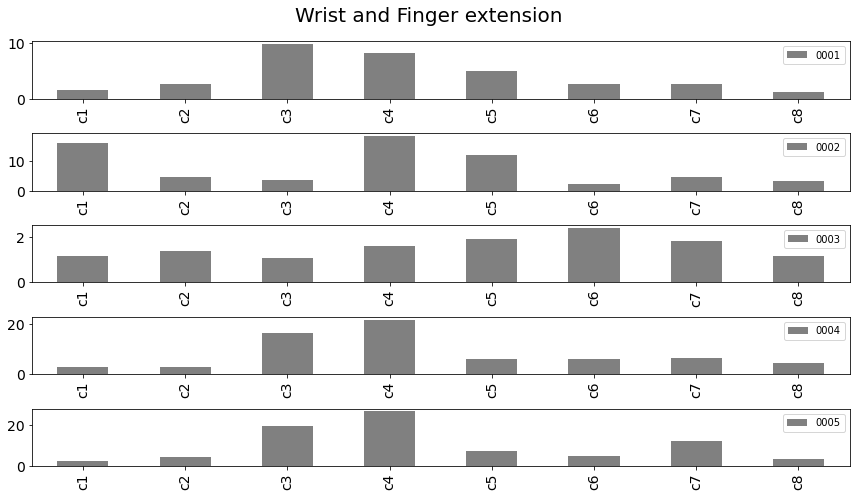

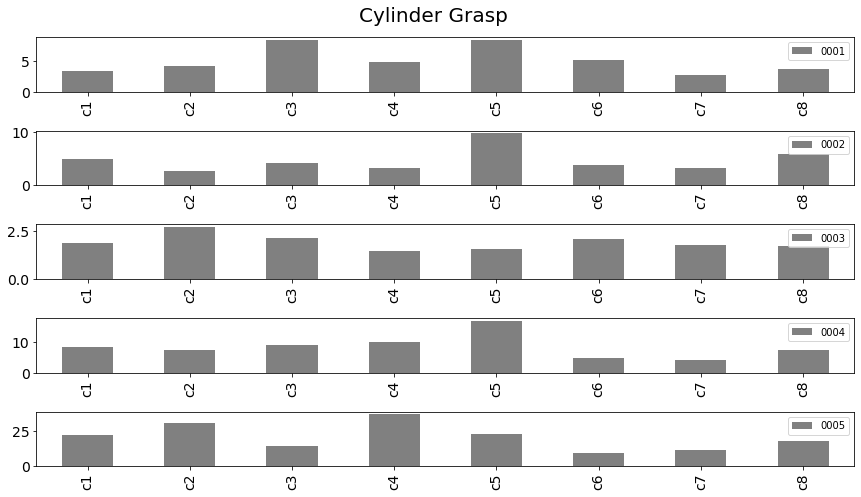

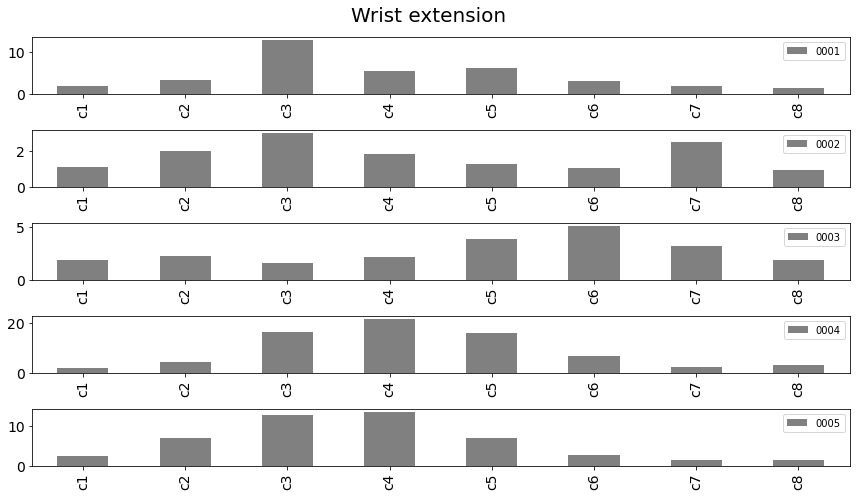

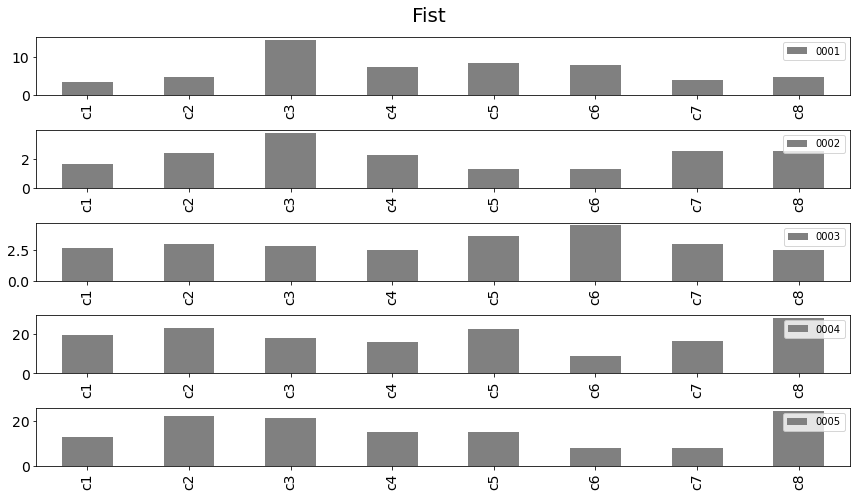

In [7]:
visualize_emg(df, 'S1', '8', 'Wrist and Finger extension', color = 'grey')
visualize_emg(df, 'S1', '2', 'Cylinder Grasp', color = 'grey')
visualize_emg(df, 'S1', '4', 'Wrist extension', color = 'grey')
visualize_emg(df, 'S1', '5', 'Fist', color = 'grey')

# Within session 

In [12]:
%%time
subject_list = df['ID'].unique()
acc_list = []
confusion_matrix_list = []
stats = []
for subject in ['0001', '0002', '0003', '0004', '0005']:
    
    for session in ['S1']:
#         print(f"\n\x1b[31m\"Current session: {session}\"\x1b[0m")
        ### Takes only the gestures that we are interested in
        df_subject = df[(df['ID'] == subject) 
                        & (df['session'] == session) 
                        & (df['Gesture'] != '0') 
                        & (df['Gesture'] != '1') 
                        & (df['Gesture'] != '3')
                        & (df['Gesture'] != '7')
                        & (df['Gesture'] != '10')
                        & (df['Gesture'] != '11')]
        
        ### Skip current loop if no matching subject is found
        if len(df_subject) == 0:
            continue
            
        ### Iterate through all trials in sessions    
        for trial_test in [1, 2, 3]:
            df_subject_train = df_subject[(df_subject['Trial_num'] != trial_test) & (df_subject.index > 100) & (df_subject.index < df_subject.index[-1] - 100)].copy()
            df_subject_test = df_subject[(df_subject['Trial_num'] == trial_test) & (df_subject.index > 100) & (df_subject.index < df_subject.index[-1] - 100)].copy()
            
            ### Take the last 100 samples (0.5 second as the validation set)
            df_subject_train.reset_index(inplace = True, drop = True)
            df_subject_val = df_subject_train.groupby(['Gesture', 'session', 'Trial_num']).tail(100)

            df_subject_train.loc[df_subject_val.index, :] = np.nan
            df_subject_train.dropna(inplace = True, axis = 0)
            
            ### Preprocess the data into overlapping windows and filter with a high pass filter
            print('\n==================================')
            print('Preprocess and filter the EMG data')
            print('==================================')

            print('Training Data')
            X_train, y_train, _= preprocess(df_subject_train, window_size = 52, nonoverlap_size = 5)
            
            print('Validation Data')
            X_val, y_val, _ = preprocess(df_subject_val, window_size = 52, nonoverlap_size = 5)
            
            print('Test Data')
            X_test, y_test, _ = preprocess(df_subject_test, window_size = 52, nonoverlap_size = 5)
            
            ### Label encoding the gesture
            le = LabelEncoder()
            y_train = le.fit_transform(y_train)
            y_val = le.transform(y_val)
            y_test = le.transform(y_test)
            
            ### One-hot encoding
            y_train = to_categorical(y_train)
            y_val = to_categorical(y_val)
            y_test = to_categorical(y_test)
            
            ### Feature scaling using standardization
            standard_scaler = StandardScaler()
            X_train = standard_scaler.fit_transform(X_train.reshape(-1, 8)).reshape(X_train.shape)
            X_val = standard_scaler.transform(X_val.reshape(-1, 8)).reshape(X_val.shape)
            X_test = standard_scaler.transform(X_test.reshape(-1, 8)).reshape(X_test.shape)
            
            ### Reshape the array into (data length, window_size, EMG_channel_size, channel [Greyscale])
            ### The default shape of the EMG snapshot is (data_length, 52, 8, 1)
            X_train = X_train.reshape((-1, X_train.shape[1], X_train.shape[2], 1))
            X_val = X_val.reshape((-1, X_val.shape[1], X_val.shape[2], 1))
            X_test = X_test.reshape((-1, X_test.shape[1], X_test.shape[2], 1))
                
            ### Create the CNN model with dropout and L2 regularization)
            model = get_CNN_model(X_train.shape, y_train.shape[1], dr = 0.5, wd = 0.01)

            model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), 
                      loss = tf.keras.losses.CategoricalCrossentropy(),
                      metrics = [tf.keras.metrics.CategoricalAccuracy(name = 'acc')])
            reduce_lr = ReduceLROnPlateau(monitor = 'val_acc', patience = 3, mode = 'max', verbose = 0)
            early_stopping = EarlyStopping(monitor = 'val_acc', patience = 10, mode = 'max', verbose = 0)
            print('\n==================================')
            print('         Start training           ')
            print('==================================')
            print(f'Shape of training data {X_train.shape}')
            print(f'Shape of validation data {X_val.shape}')
            print(f'Shape of test data {X_test.shape}')
            history = model.fit(X_train, y_train, 
                                validation_data = (X_val, y_val), 
                                callbacks = [reduce_lr, early_stopping], 
                                epochs = 30, verbose = 0)
            acc_val = model.evaluate(X_val, y_val, verbose = 0)[1]
            acc = model.evaluate(X_test, y_test, verbose = 0)[1]
            print(f'Accuracy of trial {trial_test}: %.2f' % (acc))
            acc_list.append(acc)
            y_pred = np.argmax(model.predict(X_test), axis = -1)
            y_test = np.argmax(y_test, axis = -1)
            matrix = confusion_matrix(y_test, y_pred)
            cm = pd.DataFrame(matrix, columns = Gesture_list, index = Gesture_list)
            cm['ID'] = subject
            confusion_matrix_list.append(cm)
            stats.append({'ID': subject,
                          'Trial_num': trial_test,
                          'Session': session,
                          'Accuracy': acc,
                          'confusion_matrix': cm, 
                          'history_list': history})


Preprocess and filter the EMG data
Training Data
Processing subject: 0001
Validation Data
Processing subject: 0001
Test Data
Processing subject: 0001

         Start training           
Shape of training data (1500, 52, 8, 1)
Shape of validation data (120, 52, 8, 1)
Shape of test data (870, 52, 8, 1)
Accuracy of trial 1: 0.89

Preprocess and filter the EMG data
Training Data
Processing subject: 0001
Validation Data
Processing subject: 0001
Test Data
Processing subject: 0001

         Start training           
Shape of training data (1500, 52, 8, 1)
Shape of validation data (120, 52, 8, 1)
Shape of test data (870, 52, 8, 1)
Accuracy of trial 2: 0.97

Preprocess and filter the EMG data
Training Data
Processing subject: 0001
Validation Data
Processing subject: 0001
Test Data
Processing subject: 0001

         Start training           
Shape of training data (1500, 52, 8, 1)
Shape of validation data (120, 52, 8, 1)
Shape of test data (870, 52, 8, 1)
Accuracy of trial 3: 0.88

Preprocess a

In [13]:
stats = pd.DataFrame(stats)
pd.DataFrame(stats).set_index('ID', inplace = True)
stats

,Trial_num,Session,Accuracy,confusion_matrix,history_list
ID,,,,,
0001,1,S1,0.885057,Cylinder Grasp Wrist ...,<tensorflow.python.keras.callbacks.History obj...
0001,2,S1,0.973563,Cylinder Grasp Wrist ...,<tensorflow.python.keras.callbacks.History obj...
0001,3,S1,0.875862,Cylinder Grasp Wrist ...,<tensorflow.python.keras.callbacks.History obj...
0002,1,S1,0.846756,Cylinder Grasp Wrist ...,<tensorflow.python.keras.callbacks.History obj...
0002,2,S1,0.780761,Cylinder Grasp Wrist ...,<tensorflow.python.keras.callbacks.History obj...
0002,3,S1,0.822148,Cylinder Grasp Wrist ...,<tensorflow.python.keras.callbacks.History obj...
0003,1,S1,0.549784,Cylinder Grasp Wrist ...,<tensorflow.python.keras.callbacks.History obj...
0003,2,S1,0.633117,Cylinder Grasp Wrist ...,<tensorflow.python.keras.callbacks.History obj...
0003,3,S1,0.621212,Cylinder Grasp Wrist ...,<tensorflow.python.keras.callbacks.History obj...


In [14]:
# stats.iloc[:, :-1].to_pickle('Stats_within_session_Patients.pkl')
stats = pd.read_pickle('Stats_within_session_Patients.pkl')

In [16]:
print('Accuracy %.2f +/- %.2f' %(np.mean(acc_list), np.std(acc_list)))

Accuracy 0.84 +/- 0.13


In [19]:
Matrix_1 = stats['confusion_matrix'].sum().iloc[:, :6]
Matrix_1 = Matrix_1 / Matrix_1.astype('float').sum(axis = 1)
Matrix_1 * 100

,Cylinder Grasp,Wrist Extension,Fist,Finger mass extension,Wrist/Finger Extension,Lateral Pinch
Cylinder Grasp,82.769097,4.991319,6.770833,1.562500,0.651042,3.255208
Wrist Extension,0.000000,83.203125,2.213542,1.258681,11.414931,1.909722
Fist,1.822917,10.633681,84.114583,2.300347,0.607639,0.520833
Finger mass extension,0.260417,4.861111,0.000000,75.000000,13.585069,6.293403
Wrist/Finger Extension,0.000000,3.645833,2.300347,6.423611,86.024306,1.605903
Lateral Pinch,0.217014,2.560764,0.824653,0.520833,5.295139,90.581597


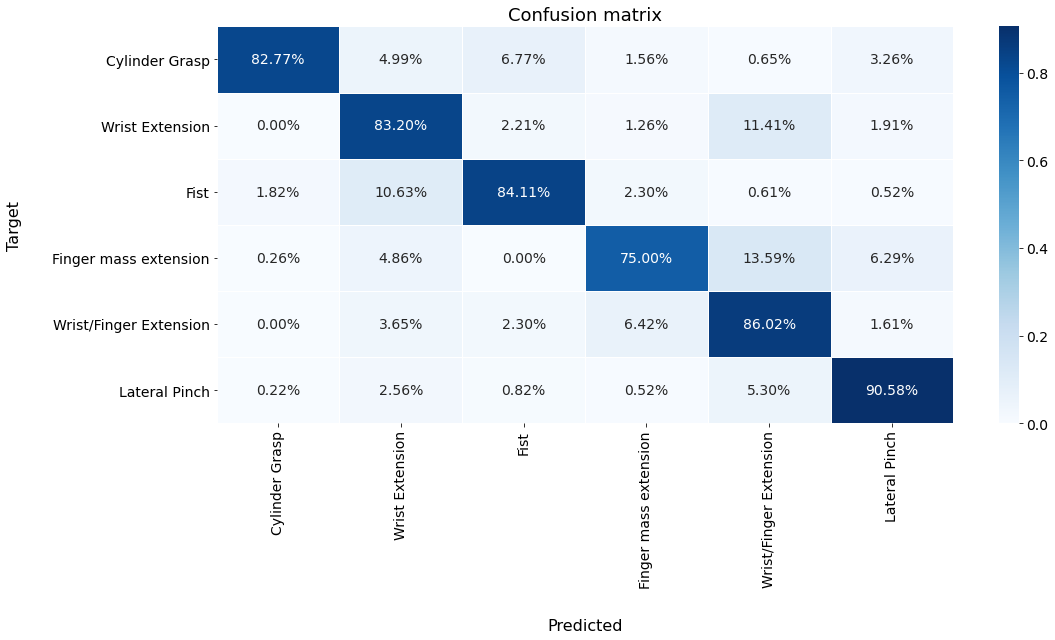

In [23]:
fig = plt.figure(figsize = (16, 9))
sns.heatmap(Matrix_1, cmap = 'Blues', annot=True, fmt=".2%", linewidths=1.0, annot_kws={"fontsize":14})
plt.title('Confusion matrix', fontsize = 18)
plt.ylabel('Target', labelpad = 30, fontsize = 16)
plt.xlabel('Predicted', labelpad = 30, fontsize = 16)
plt.tight_layout()